Logistic Regression:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         7

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

Random Forest:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         7

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18

XGBoost:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         7

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00   

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:43:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:43:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


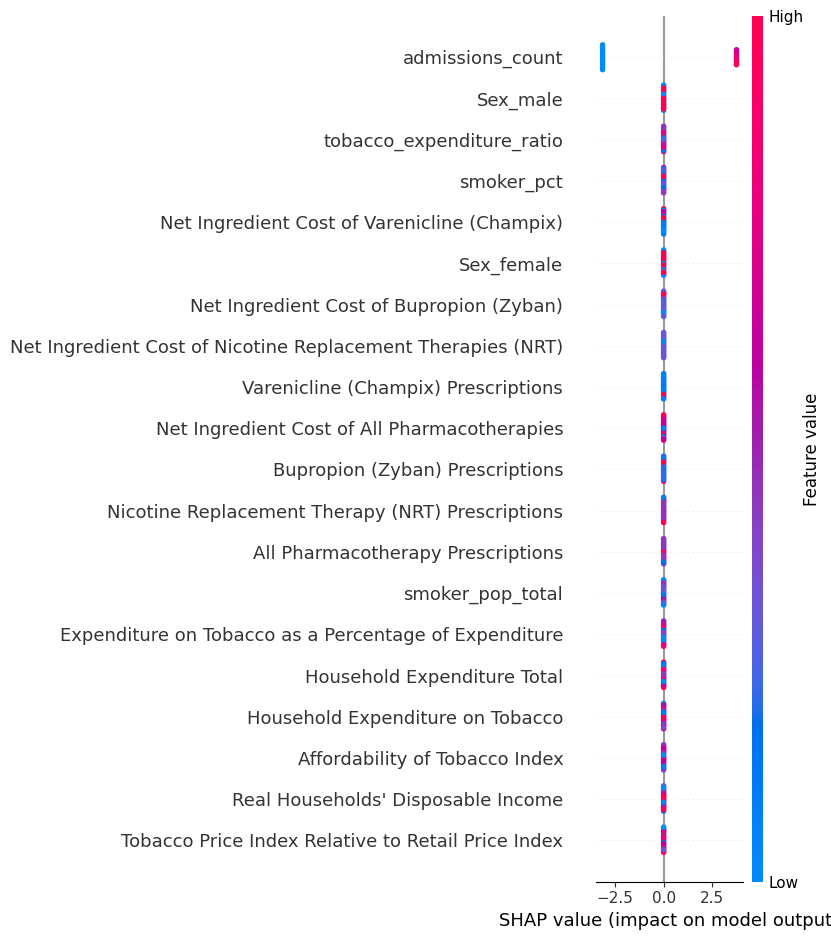

Saved pipeline to: /content/final_mortality_pipeline.joblib


In [ ]:
# 1. Imports
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.utils import resample
import shap
import joblib

# 2. Helper functions
def parse_year(year_val):
    """Normalize year values."""
    if pd.isna(year_val):
        return np.nan
    if isinstance(year_val, (int, float)):
        return int(year_val)
    s = str(year_val)
    m = re.match(r"(\d{4})/(\d{2,4})", s)
    if m:
        return int(m.group(1))
    m2 = re.search(r"(\d{4})", s)
    if m2:
        return int(m2.group(1))
    try:
        return int(float(s))
    except:
        return np.nan

def to_numeric_safe(s):
    try:
        return pd.to_numeric(s, errors='coerce')
    except:
        return np.nan

# 3. Load datasets
DATA_DIR = '/content'
smokers = pd.read_csv(os.path.join(DATA_DIR, 'smokers.csv'))
admissions = pd.read_csv(os.path.join(DATA_DIR, 'admissions.csv'))
metrices = pd.read_csv(os.path.join(DATA_DIR, 'metrics.csv'))
fatalities = pd.read_csv(os.path.join(DATA_DIR, 'fatalities.csv'))
prescriptions = pd.read_csv(os.path.join(DATA_DIR, 'prescriptions.csv'))

# 4. Clean and normalize datasets

# 4.1 Smokers
smokers_clean = smokers.copy()
smokers_clean.columns = [c.strip() for c in smokers_clean.columns]
smokers_clean['Year'] = smokers_clean['Year'].apply(parse_year)
age_cols = ['16 and Over','16-24','25-34','35-49','50-59','60 and Over']
for c in age_cols:
    smokers_clean[c] = to_numeric_safe(smokers_clean[c])
smokers_clean['smoker_pop_total'] = smokers_clean[age_cols].sum(axis=1, skipna=True)
smokers_clean['Sex'] = smokers_clean['Sex'].str.lower().str.strip()

# 4.2 Admissions
admissions_clean = admissions.copy()
admissions_clean.columns = [c.strip() for c in admissions_clean.columns]
admissions_clean['Year'] = admissions_clean['Year'].apply(parse_year)
admissions_clean['Value'] = admissions_clean['Value'].apply(to_numeric_safe)
admissions_clean['Sex'] = admissions_clean['Sex'].str.lower().str.strip()

# 4.3 Metrices
metrices_clean = metrices.copy()
metrices_clean.columns = [c.strip() for c in metrices_clean.columns]
metrices_clean['Year'] = metrices_clean['Year'].apply(parse_year)
for c in metrices_clean.columns:
    if c != 'Year':
        metrices_clean[c] = to_numeric_safe(metrices_clean[c])

# 4.4 Fatalities
fatalities_clean = fatalities.copy()
fatalities_clean.columns = [c.strip() for c in fatalities_clean.columns]
fatalities_clean['Year'] = fatalities_clean['Year'].apply(parse_year)
fatalities_clean['Value'] = fatalities_clean['Value'].apply(to_numeric_safe)
fatalities_clean['Sex'] = fatalities_clean['Sex'].str.lower().str.strip()

# 4.5 Prescriptions
presc_clean = prescriptions.copy()
presc_clean.columns = [c.strip() for c in presc_clean.columns]
for c in presc_clean.columns:
    if 'year' in c.lower():
        presc_clean[c] = presc_clean[c].apply(parse_year)
        presc_clean = presc_clean.rename(columns={c:'Year'})
for c in presc_clean.columns:
    if c != 'Year':
        presc_clean[c] = to_numeric_safe(presc_clean[c])

# 5. Aggregate and merge datasets
# Admissions and fatalities aggregated by Year and Sex
admissions_agg = admissions_clean.groupby(['Year','Sex'], dropna=False)['Value'].sum().reset_index().rename(columns={'Value':'admissions_count'})
fatalities_agg = fatalities_clean.groupby(['Year','Sex'], dropna=False)['Value'].sum().reset_index().rename(columns={'Value':'fatalities_count'})
smk_agg = smokers_clean.groupby(['Year','Sex'], dropna=False)['smoker_pop_total'].sum().reset_index()

# Merge all datasets
df = pd.merge(metrices_clean, smk_agg, on='Year', how='left')
df = pd.merge(df, admissions_agg.groupby('Year')['admissions_count'].sum().reset_index(), on='Year', how='left')
df = pd.merge(df, fatalities_agg.groupby('Year')['fatalities_count'].sum().reset_index(), on='Year', how='left')
df = pd.merge(df, presc_clean, on='Year', how='left')

# Fill missing fatalities/admissions
df['fatalities_count'] = df['fatalities_count'].fillna(0)
df['admissions_count'] = df['admissions_count'].fillna(0)

# 6. Feature engineering
# Mortality flag: 1 if fatalities_count above median
threshold = df['fatalities_count'].median()
df['mortality_flag'] = (df['fatalities_count'] > threshold).astype(int)

# Smoking prevalence percentage
if 'smoker_pop_total' in df.columns:
    df['smoker_pct'] = df['smoker_pop_total'] / df['smoker_pop_total'].max()

# Tobacco expenditure ratio
if 'Household Expenditure on Tobacco' in df.columns and 'Household Expenditure Total' in df.columns:
    df['tobacco_expenditure_ratio'] = df['Household Expenditure on Tobacco'] / df['Household Expenditure Total']

# 7. Prepare data for modeling
X = df.drop(columns=['Year','fatalities_count','mortality_flag'])
y = df['mortality_flag']

# Identify numerical and categorical
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()

# Preprocessing pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle class imbalance by upsampling minority
if y_train.value_counts().min()/y_train.value_counts().max() < 0.5:
    Xy_train = pd.concat([X_train, y_train], axis=1)
    majority = Xy_train[Xy_train['mortality_flag']==0]
    minority = Xy_train[Xy_train['mortality_flag']==1]
    minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
    upsampled = pd.concat([majority, minority_upsampled])
    X_train = upsampled.drop(columns=['mortality_flag'])
    y_train = upsampled['mortality_flag']

# 8. Model training
# Logistic Regression
lr_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
print('Logistic Regression:\n', classification_report(y_test, y_pred_lr))

# Random Forest
rf_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
print('Random Forest:\n', classification_report(y_test, y_pred_rf))

# XGBoost
xgb_pipeline = Pipeline([('preprocessor', preprocessor), ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
print('XGBoost:\n', classification_report(y_test, y_pred_xgb))

# 9. SHAP feature importance for XGBoost
preprocessor.fit(X_train)
X_test_pre = preprocessor.transform(X_test)
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(preprocessor.transform(X_train), y_train)
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test_pre)
feature_names = num_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features))
shap.summary_plot(shap_values, X_test_pre, feature_names=feature_names, show=True)

# 10. Save final XGBoost pipeline
final_pipeline = xgb_pipeline
joblib.dump(final_pipeline, os.path.join(DATA_DIR, 'final_mortality_pipeline.joblib'))
print('Saved pipeline to:', os.path.join(DATA_DIR, 'final_mortality_pipeline.joblib'))


Random Forest Regressor Metrics:
RMSE: 613748.2776156951
MAE: 158798.93555555554
R²: 0.8293846555908266

XGBoost Regressor Metrics:
RMSE: 721752.4357640628
MAE: 170118.73611111112
R²: 0.7640532330235033


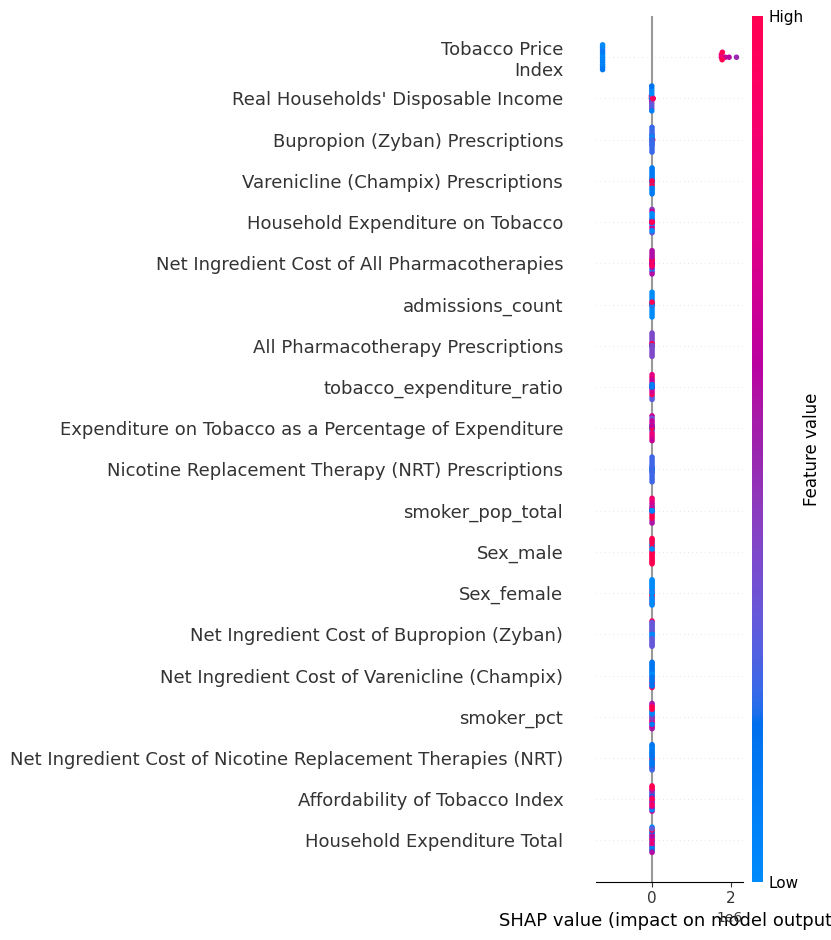

Saved regression pipeline to: /content/final_mortality_regression_pipeline.joblib


In [ ]:
# 11. Regression modeling for fatalities_count (fully corrected for modern SHAP)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import shap
import joblib

# Target for regression
y_reg = df['fatalities_count']

# Train/test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# Random Forest Regressor
rf_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test_reg)

# Evaluate Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf_reg))
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf_reg)
r2_rf = r2_score(y_test_reg, y_pred_rf_reg)

print("Random Forest Regressor Metrics:")
print("RMSE:", rmse_rf)
print("MAE:", mae_rf)
print("R²:", r2_rf)

# XGBoost Regressor
xgb_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42))
])
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred_xgb_reg = xgb_reg.predict(X_test_reg)

# Evaluate XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb_reg))
mae_xgb = mean_absolute_error(y_test_reg, y_pred_xgb_reg)
r2_xgb = r2_score(y_test_reg, y_pred_xgb_reg)

print("\nXGBoost Regressor Metrics:")
print("RMSE:", rmse_xgb)
print("MAE:", mae_xgb)
print("R²:", r2_xgb)

# SHAP feature importance for XGBoost regression
background = X_train_reg.sample(min(100, len(X_train_reg)), random_state=42)
X_test_reg_pre = preprocessor.transform(X_test_reg)
background_pre = preprocessor.transform(background)

explainer_reg = shap.TreeExplainer(
    xgb_reg.named_steps['regressor'],
    data=background_pre,
    feature_perturbation='interventional'
)

shap_values_reg = explainer_reg.shap_values(X_test_reg_pre)

# Build feature names (numeric + one-hot encoded)
feature_names = num_features.copy()
if len(cat_features) > 0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(cat_features)
    feature_names += list(cat_names)

# SHAP summary plot
shap.summary_plot(shap_values_reg, X_test_reg_pre, feature_names=feature_names, show=True)

# Save regression pipeline
joblib.dump(xgb_reg, os.path.join(DATA_DIR, 'final_mortality_regression_pipeline.joblib'))
print('Saved regression pipeline to:', os.path.join(DATA_DIR, 'final_mortality_regression_pipeline.joblib'))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [10:55:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Metrics for mortality_flag:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC-AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         7

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



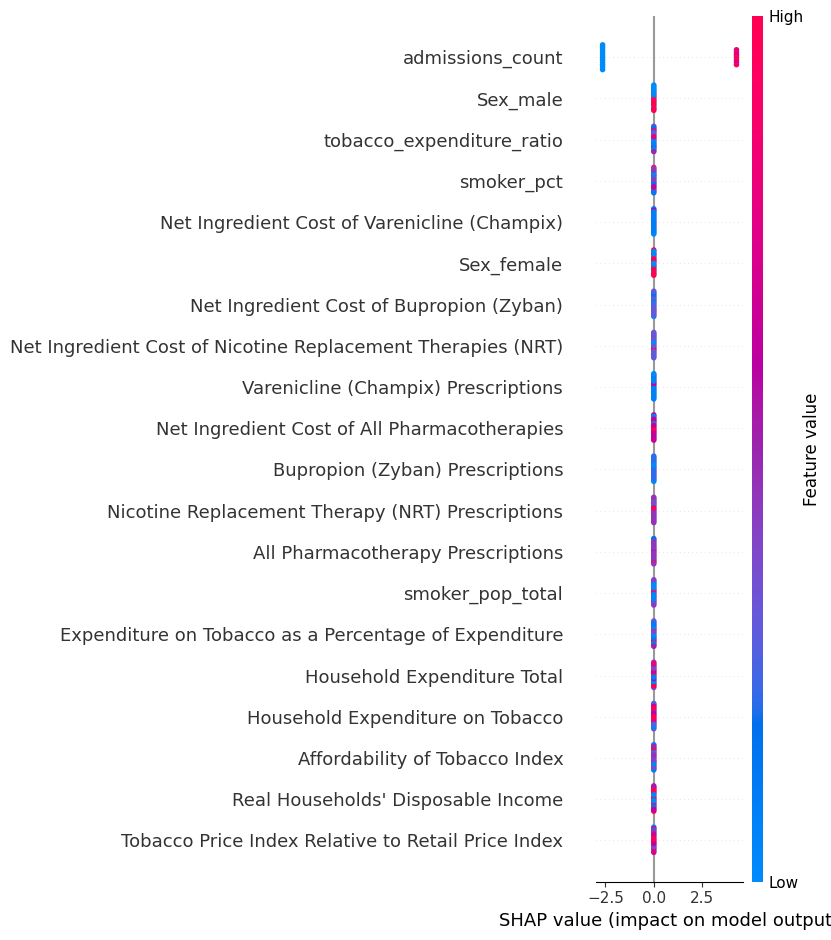

Saved classification pipeline to: /content/final_mortality_classification_pipeline.joblib


In [ ]:
# 12. Classification modeling: mortality_flag (binary)

# Create binary target
# mortality_flag = 1 if fatalities_count > median, else 0
threshold = df['fatalities_count'].median()
df['mortality_flag'] = (df['fatalities_count'] > threshold).astype(int)

y_class = df['mortality_flag']

# Train/test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_class, test_size=0.2, stratify=y_class, random_state=42
)

# handle class imbalance by upsampling minority
if y_train_clf.value_counts().min() / y_train_clf.value_counts().max() < 0.5:
    Xy_train = pd.concat([X_train_clf, y_train_clf], axis=1)
    majority = Xy_train[Xy_train['mortality_flag']==0]
    minority = Xy_train[Xy_train['mortality_flag']==1]
    minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
    upsampled = pd.concat([majority, minority_upsampled])
    y_train_clf = upsampled['mortality_flag']
    X_train_clf = upsampled.drop(columns=['mortality_flag'])

# XGBoost Classifier pipeline
xgb_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
xgb_clf.fit(X_train_clf, y_train_clf)

# Predictions
y_pred_clf = xgb_clf.predict(X_test_clf)
y_prob_clf = xgb_clf.predict_proba(X_test_clf)[:,1]

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

print("Classification Metrics for mortality_flag:")
print("Accuracy:", accuracy_score(y_test_clf, y_pred_clf))
print("Precision:", precision_score(y_test_clf, y_pred_clf))
print("Recall:", recall_score(y_test_clf, y_pred_clf))
print("F1 Score:", f1_score(y_test_clf, y_pred_clf))
print("ROC-AUC:", roc_auc_score(y_test_clf, y_prob_clf))
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred_clf))

# SHAP for classification
background_clf = X_train_clf.sample(min(100, len(X_train_clf)), random_state=42)
X_test_clf_pre = preprocessor.transform(X_test_clf)
background_clf_pre = preprocessor.transform(background_clf)

explainer_clf = shap.TreeExplainer(
    xgb_clf.named_steps['classifier'],
    data=background_clf_pre,
    feature_perturbation='interventional'
)

shap_values_clf = explainer_clf.shap_values(X_test_clf_pre)

# Feature names
feature_names_clf = num_features.copy()
if len(cat_features) > 0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_names = ohe.get_feature_names_out(cat_features)
    feature_names_clf += list(cat_names)

# SHAP summary plot
shap.summary_plot(shap_values_clf, X_test_clf_pre, feature_names=feature_names_clf, show=True)

# Save classification pipeline
joblib.dump(xgb_clf, os.path.join(DATA_DIR, 'final_mortality_classification_pipeline.joblib'))
print("Saved classification pipeline to:", os.path.join(DATA_DIR, 'final_mortality_classification_pipeline.joblib'))
